# Transfer a pre-trained model to new data

This tutorial shows how to load a pre-trained SpaHDmap model to perform model transfer. This is particularly useful when you want to apply the SpaHDmap framework to new datasets without retraining the model from scratch.

We will use the results from the [Step-by-step guide for SpaHDmap workflow](./HE-image.ipynb) tutorial as an illustrative example, where a SpaHDmap model has already been trained on the first posterior section of the mouse brain. Subsequently, we will transfer this model to a new section of the mouse brain that is adjacent to the initial section. The relevant data can be downloaded from [10X Genomics](https://www.10xgenomics.com/datasets/mouse-brain-serial-section-2-sagittal-posterior-1-standard-1-1-0) or [Google Drive](https://drive.google.com/file/d/1cqD7QJ_TkB5FKrfi8xZsAmmtgoAHzTSG/view?usp=drive_link).

## 1. Import necessary libraries

In [2]:
import torch
import numpy as np
import scanpy as sc

import SpaHDmap as hdmap

/home/qk/anaconda3/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


## 2. Set parameters and paths

Define the parameters and file paths. Note that the `rank` and `scale_rate` should match the settings used in the original SpaHDmap run.

The `results_path` can be set as the path where the SpaHDmap model and metagene matrix are saved from the previous section. If you want to use a new results path, you need to load the metagene matrix and pre-trained model from the previous section.

In [3]:
rank = 20 # This should match the rank used in the original SpaHDmap run
seed = 123
scale_rate = 1

verbose = True

np.random.seed(seed)
torch.manual_seed(seed)

root_path = '../experiments'
project = 'MPBS01'
results_path = f'{root_path}/{project}/Results_Rank{rank}/'

print(f"Expecting saved STData object in: {results_path}")

Expecting saved STData object in: ../experiments/MPBS01/Results_Rank20/


## 3. Load new data

In this tutorial, we will load the adjacent 10X Visium ST dataset MPBS-02 of the same mouse brain, could be downloaded from [10X Genomics](https://www.10xgenomics.com/datasets/mouse-brain-serial-section-2-sagittal-posterior-1-standard-1-1-0) or [Google Drive](https://drive.google.com/file/d/1cqD7QJ_TkB5FKrfi8xZsAmmtgoAHzTSG/view?usp=drive_link).

In this case, please set `select_hvgs=False` to skip the selection of highly variable genes, since the SVGs have been selected in the previous section. The `scale_rate` should be set to the same values as in the previous section, otherwise the model transfer will not work well.

In [4]:
# previous section_id is 'V1_Mouse_Brain_Sagittal_Posterior_Section_1'
section_id = 'V1_Mouse_Brain_Sagittal_Posterior_Section_2'

adata2 = sc.datasets.visium_sge(section_id, include_hires_tiff=True)
image_path2 = adata2.uns["spatial"][section_id]["metadata"]["source_image_path"]

mouse_posterior2 = hdmap.prepare_stdata(adata=adata2,
                                        section_name='mouse_posterior2',
                                        image_path=image_path2,
                                        scale_rate=scale_rate,
                                        select_hvgs=False)

/tmp/ipykernel_3669373/456689964.py:4: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata2 = sc.datasets.visium_sge(section_id, include_hires_tiff=True)


  0%|          | 0.00/9.26M [00:00<?, ?B/s]

  0%|          | 0.00/19.0M [00:00<?, ?B/s]

  0%|          | 0.00/386M [00:00<?, ?B/s]

/home/qk/anaconda3/lib/python3.11/site-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


*** Reading and preparing AnnData for section mouse_posterior2 ***
Spot radius found in AnnData: 45
Pre-processing gene expression data for 3289 spots and 32285 genes.
Swapping x and y coordinates.
Processing image, seems to be HE image.


## 4. Run SpaHDmap for new data

If SpaHDmap has been run for the previous section, with setting the same `results_path` and `rank`, calling the function `load_metagene`, and set `load_model=True`, you can directly load the model and run SpaHDmap for the new section.

In this case, SpaHDmap will calculate the NMF score based on the previous `metagene_NMF` matrix, and only train the GCN model for the new section.

In [5]:
# Initialize the SpaHDmap runner
mapper = hdmap.Mapper(mouse_posterior2, results_path=results_path, rank=rank, verbose=verbose)
# Load the metagene_NMF from the previous section in this results path
mapper.load_metagene()

# Run SpaHDmap
mapper.run_SpaHDmap(save_score=False, save_model=True, load_model=True, visualize=True)

*** Preparing the tissue splits and creating pseudo spots... ***
*** Single section detected. Using its 18979 genes. ***
*** The split size is set to 256 pixels. ***
For section mouse_posterior2, divide the tissue into 1397 sub-tissues, and create 15000 pseudo spots.
*** Using GPU ***
*** Loaded both metagene_NMF and metagene from ../experiments/MPBS01/Results_Rank20/ ***
*** Adding 3 missing genes with zero expression. ***
Step 1: Run NMF
*** Using existing metagene for transfer learning... ***
*** Visualizing and saving the embeddings of NMF... ***
Step 2: Pre-train the SpaHDmap model
*** Pre-trained model found at ../experiments/MPBS01/Results_Rank20//models//pretrained_model.pth, loading... ***
Step 3: Train the GCN model
*** Performing GCN... ***
*** Training GCN for mouse_posterior2... ***
[Iter: 200 / 5000], Loss: 0.019648, Learning rate: 4.985215e-03
[Iter: 400 / 5000], Loss: 0.005862, Learning rate: 4.941093e-03
[Iter: 600 / 5000], Loss: 0.005298, Learning rate: 4.868331e-03
[

*** Visualizing and saving the embeddings of SpaHDmap... ***


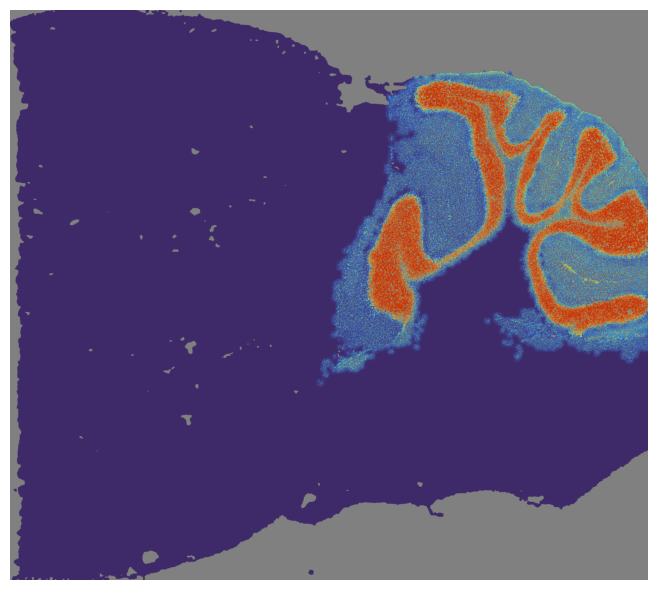

In [7]:
# Visualize the SpaHDmap score for new data
mapper.visualize(mouse_posterior2, use_score='SpaHDmap', index=2)

Or for a new results path, you need to provide the `results_path` to function `load_metagene`, and change the path of the models `mapper.model_path` before running SpaHDmap.

In [8]:
# Set a new results path for the new section
root_path = '../experiments/'
project = 'MPBS02'
results_path_new = f'{root_path}/{project}/Results_Rank{rank}/'

# Initialize the SpaHDmap runner with a new results path, load the metagene matrix and pre-trained model
mapper = hdmap.Mapper(mouse_posterior2, results_path=results_path_new, rank=rank, verbose=verbose)
mapper.load_metagene(results_path)
mapper.model_path = f'{results_path}/models/'

# Run SpaHDmap
mapper.run_SpaHDmap(save_score=False, save_model=True, load_model=True, visualize=True)

*** Preparing the tissue splits and creating pseudo spots... ***
*** Using GPU ***
*** Loaded both metagene_NMF and metagene from ../experiments/MPBS01/Results_Rank20/ ***
Step 1: Run NMF
*** Using existing metagene for transfer learning... ***
*** Visualizing and saving the embeddings of NMF... ***
Step 2: Pre-train the SpaHDmap model
*** Pre-trained model found at ../experiments/MPBS01/Results_Rank20//models//pretrained_model.pth, loading... ***
Step 3: Train the GCN model
*** Performing GCN... ***
*** Training GCN for mouse_posterior2... ***
[Iter: 200 / 5000], Loss: 0.015210, Learning rate: 4.985215e-03
[Iter: 400 / 5000], Loss: 0.005378, Learning rate: 4.941093e-03
[Iter: 600 / 5000], Loss: 0.005059, Learning rate: 4.868331e-03
[Iter: 800 / 5000], Loss: 0.004964, Learning rate: 4.768075e-03
[Iter: 1000 / 5000], Loss: 0.004919, Learning rate: 4.641907e-03
[Iter: 1200 / 5000], Loss: 0.004891, Learning rate: 4.491816e-03
[Iter: 1400 / 5000], Loss: 0.004870, Learning rate: 4.320170e-0

*** Visualizing and saving the embeddings of SpaHDmap... ***


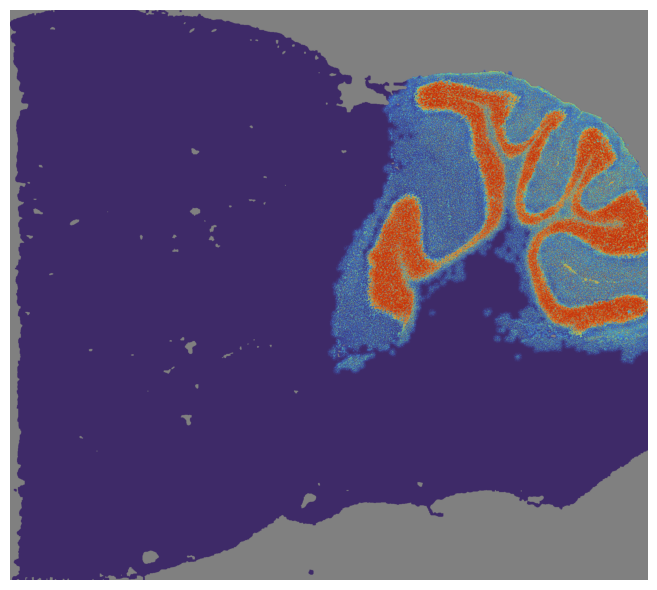

In [45]:
# Visualize the SpaHDmap score for new data
mapper.visualize(mouse_posterior2, use_score='SpaHDmap', index=2)